In [52]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import helpers
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from importlib import reload
helpers = reload(helpers)

In [2]:
def get_opt():
    #All parameters are defualt mentioned in paper
    return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



In [3]:
def encoder_conv_block_batch_norm(inputs, n_filters, dropout, kernel_size=3, batchNorm = True):
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(inputs)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
        # second layer
    net = Dropout(dropout)(net)
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(net)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
    return net

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [5]:
def get_unet_3(dropout, input_img):
    inputs = input_img
    patch_size = 32
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_last')(conv5)
    conv6 = core.Reshape((2,32*32))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [6]:
def unet_gen(dropout, input_img, transposedConv, n_filters = 32):
    inputs = input_img
    patch_size = 32
    block1 = encoder_conv_block_batch_norm(inputs, n_filters =n_filters,
                                  kernel_size=3, dropout = dropout*0.5)
    pool1 = MaxPooling2D((2, 2))(block1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    #pool1 = MaxPooling2D((2, 2))(conv1)
    #
    block2 = encoder_conv_block_batch_norm(pool1, n_filters = n_filters*2,
                                  kernel_size=3, dropout = dropout)
    pool2 = MaxPooling2D((2, 2))(block2) 
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    #pool2 = MaxPooling2D((2, 2))(conv2)
    #
    bridge = encoder_conv_block_batch_norm(pool2, n_filters = n_filters*4,
                                  kernel_size=3, dropout = dropout)
    
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)
    up1 = bridge
    if transposedConv:
        up1 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (up1)
    else:
        up1 = UpSampling2D(size=(2, 2))(up1)
    up1 = concatenate([block2,up1])
    up_block2 = encoder_conv_block_batch_norm(up1, n_filters = n_filters*2,
                                  kernel_size=3, dropout= dropout)
    
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    #conv4 = Dropout(dropout)(conv4)
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = up_block2
    if transposedConv:
        up2 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (up2)
    else:
        up2 = UpSampling2D(size=(2, 2))(up2)
    up2 = concatenate([block1,up2])
    up_block1 = encoder_conv_block_batch_norm(up2, n_filters = n_filters,
                                  kernel_size=3, dropout = dropout)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    #conv5 = Dropout(dropout)(conv5)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    outputs = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(up_block1)
    #conv6 = core.Reshape((2,32*32))(conv6)
    #conv6 = core.Permute((2,1))(conv6)
    ############
    #conv7 = core.Activation('softmax')(conv6)
    opt = get_opt()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [7]:
def get_transp_conv_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = True)

In [8]:
def get_up_sample_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = False)

In [9]:
def get_unet_seismic(input_img, dropout, n_filters=16, batchnorm=True):
    # contracting path
    print("SEISMIC UNET")
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    opt  = get_opt()
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [10]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [11]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

In [ ]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [76]:
def train(epochs, n_folds, model_dict, saveModel = False):
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    load_model = model_dict['load_model']
    args = model_dict['args']
    model = load_model(**args)
    batch_size = 32
    historyList =[]
    pathToSaveModel = "../../savedModels/"
    if saveModel:
        #if we cant save then we crash here
        model.save(pathToSaveModel + "test.h5")
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = load_model(**args)
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    elif saveModel or (n_folds == 0):
        model = load_model(**args)
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
        if saveModel:
            model.save(pathToSaveModel+model_dict['name']+".h5")
    return model, historyList
    

## Train model on the full data set, no cross validation

In [77]:
args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.05}
model_dict = {'load_model' : get_transp_conv_unet, 'args' : args1}
drive_model, historyList = train(epochs = 20, n_folds = 0, model_dict = model_dict)


Epoch 1/20
62/62 [==============================] - 7s 109ms/step - loss: 0.5456
Epoch 2/20
62/62 [==============================] - 2s 29ms/step - loss: 0.4107
Epoch 3/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3861
Epoch 4/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3811
Epoch 5/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3769
Epoch 6/20
62/62 [==============================] - 2s 28ms/step - loss: 0.3759
Epoch 7/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3728
Epoch 8/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3718
Epoch 9/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3711
Epoch 10/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3684
Epoch 11/20
62/62 [==============================] - 2s 28ms/step - loss: 0.3673
Epoch 12/20
62/62 [==============================] - 2s 29ms/step - loss: 0.3654
Epoch 13/20
62/62 [=================

## Compare n models with different parameters

In [ ]:
epochs = 100
model_name = ["TranspConv", "Seismic", "UpSample"]

load_model = [get_transp_conv_unet, get_unet_seismic, get_up_sample_unet]

dropouts = [0, 0.05, 0.1, 0.2, 0.3, 0.4]


model_dicts = []
for dropout in dropouts:
    for model_idx in range(len(model_name)):
        arg = {}
        arg['dropout'] = dropout
        arg['input_img'] = Input((32,32,1))
        model_dict = {}
        model_dict['load_model'] = load_model[model_idx]
        model_dict['args'] = arg
        model_dict['name'] = model_name[model_idx] + str(dropout)
        model_dicts.append(model_dict)


models = []
historyLists =[]
for model_dict in model_dicts:
    print(model_dict['name'])
    res, historyList = train(epochs = epochs, n_folds = 5, model_dict = model_dict)
    models.append(res)
    historyLists.append(historyList)

In [ ]:
def plotMultipleModels(full_model_history_df):
    plt.style.use('ggplot')
    ax = sns.lineplot(x="epochs", y="loss", style="type", hue= 'model', data=full_model_history_df)
    legend = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    %config InlineBackend.figure_format = 'retina'
    plt.show()

In [39]:
def plotComparisonOfModels( historyLists, model_dicts):
    full_model_history_df = pd.DataFrame()
    for cur_model_nr in range(len(model_dicts)):
        loss_data = ([i.history['loss'] for i in historyLists[cur_model_nr]])
        val_loss_data = ([i.history['val_loss'] for i in historyLists[cur_model_nr]])
        all_data = loss_data + val_loss_data
        all_data.append( [i+1 for i in range(epochs)])
        model_history_df = pd.DataFrame(all_data).T
        column_names = []
        foldLossName = []
        for i in range(len(loss_data)):
            foldLossName.append("fold"+str(i)+"_loss")
        column_names += foldLossName
        foldValLossName = []
        for i in range(len(val_loss_data)):
            foldValLossName.append("fold"+str(i)+"val_loss")
        column_names += foldValLossName
        column_names.append('epochs')
        model_history_df.columns=column_names
        model_history_df["model"] = model_dicts[cur_model_nr]['name']
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        #plt.xlabel("epoch")
        #plt.ylabel("loss")
        #plt.show()
        model_history_df = pd.melt(model_history_df, value_vars=foldLossName+ foldValLossName,
                                   id_vars = ['epochs','model'] ,value_name = "loss")
        types = ['train', 'validation']
        trainOrValidation = []
        for i in types:
            for j in range(model_history_df.shape[0]//2):
                trainOrValidation.append(i)
        model_history_df['type'] =trainOrValidation
        model_history_df = model_history_df.astype({'epochs': int})
        full_model_history_df = pd.concat([full_model_history_df, model_history_df], ignore_index = True)
    full_model_history_df.to_pickle("fullModelHistorydf.pkl")
    plotMultipleModels(full_model_history_df)


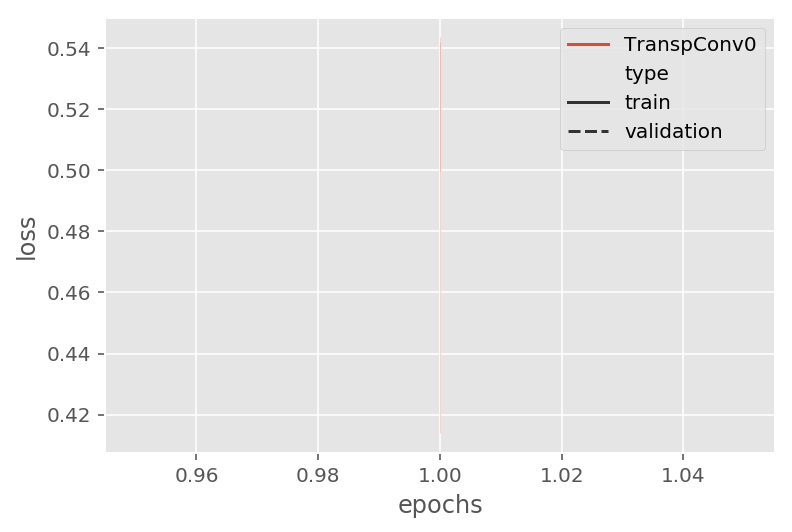

In [40]:
plotComparisonOfModels(historyLists, model_dicts)

In [ ]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [23]:
drive_test_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_test_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_test_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

drive_training_images = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_IMAGES_PATH)
drive_training_mask = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_MASK_PATH)
drive_training_segmented = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_SEG_1_PATH)

chase_training_images = helpers.load_images_from_folder(helpers.CHASE_IMAGES_PATH)
chase_training_mask = helpers.load_images_from_folder(helpers.CHASE_MASK_PATH)
chase_training_segmented = helpers.load_images_from_folder(helpers.CHASE_SEG_1_PATH)

Auc score:  0.9004809395936137
Accuracy:  0.9520316253448438
Sensitivity:  0.8306133550931593
Specificity:  0.9703485240940681


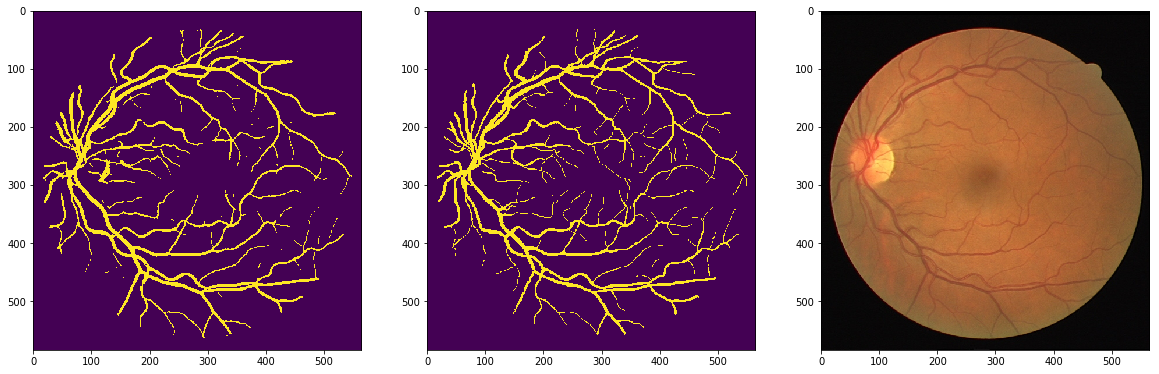

In [75]:
image_nr = 0
full_image_segmentation = helpers.segment_whole_image(drive_test_images[image_nr], drive_test_mask[image_nr], 32, helpers.Dataset.DRIVE, model)
full_image_segmentation[full_image_segmentation > 0.5] = 1
full_image_segmentation[full_image_segmentation <= 0.5] = 0
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(full_image_segmentation)
ax[1].imshow(drive_test_segmented[image_nr])
ax[2].imshow(drive_test_images[image_nr])
print('Auc score: ',helpers.roc_auc(full_image_segmentation, drive_test_segmented[image_nr], drive_test_mask[image_nr]))
print('Accuracy: ',helpers.accuracy(full_image_segmentation, drive_test_segmented[image_nr], drive_test_mask[image_nr]))
print('Sensitivity: ',helpers.sensitivity(full_image_segmentation, drive_test_segmented[image_nr], drive_test_mask[image_nr]))
print('Specificity: ',helpers.specificity(full_image_segmentation, drive_test_segmented[image_nr], drive_test_mask[image_nr]))
plt.show()

In [48]:
def get_test_score(images, mask, segmentation, model, plot=False, nr_of_images=None):
    if not nr_of_images:
        nr_of_images = len(images)
    total_auc_score = 0
    total_accuracy = 0
    total_sensitivity = 0
    total_specificity = 0
    if plot:
        fig, ax = plt.subplots(nr_of_images,3, figsize=(20,20))
    for (i, image) in enumerate(images[:nr_of_images]):
        print('Segmenting image',(i+1))
        full_image_segmentation = helpers.segment_whole_image(image, mask[i], 32, helpers.Dataset.DRIVE, model)
        total_auc_score += helpers.roc_auc(full_image_segmentation, segmentation[i], mask[i])
        total_accuracy += helpers.accuracy(full_image_segmentation, segmentation[i], mask[i])
        total_sensitivity += helpers.sensitivity(full_image_segmentation, segmentation[i], mask[i])
        total_specificity += helpers.specificity(full_image_segmentation, segmentation[i], mask[i])
        if plot:
            ax[i, 0].imshow(full_image_segmentation)
            ax[i, 1].imshow(segmentation[i])
            ax[i, 2].imshow(image)
            
    print('Average auc score: ', total_auc_score / nr_of_images)
    print('Average accuracy score: ', total_accuracy / nr_of_images)
    print('Average sensitivity score: ', total_sensitivity / nr_of_images)
    print('Average specificity score: ', total_specificity / nr_of_images)
    if plot:
        plt.show()
            

In [78]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, drive_model, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9647437951017153
Average accuracy score:  0.9441619226362766
Average sensitivity score:  0.7009085448440256
Average specificity score:  0.9799473402491596


In [28]:
def create_patches(images, segmentations, masks, n, patches_per_image):
    nrOfImages = 0
    for (i, image) in enumerate(images):
        patch_images, patch_labels = helpers.get_image_pathes(image, segmentations[i], n, patches_per_image, helpers.Dataset.CHASE, masks[i])
        for (j, patch) in enumerate(patch_images):
            name = str(i) + '_' + str(j)
            helpers.save_image('../../data/CHASEDB1/patches/' + name + '.png', patch)
            helpers.save_image('../../data/CHASEDB1/patchLabels/' + name + '.png' , patch_labels[j])
            nrOfImages += 1

In [38]:
create_patches(chase_training_images, chase_training_segmented, chase_training_mask, 32, 100)

In [80]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, transfer_model[0], False)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9706409249409302
Average accuracy score:  0.9479525695263117
Average sensitivity score:  0.7509316581213938
Average specificity score:  0.9770212278722464


In [72]:
def transfer_train(model,epochs, n_folds=0):
    for layer in model.layers[:-8]:
        layer.trainable = False
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    batch_size = 32
    historyList =[]
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = load_model(**args)
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    elif n_folds == 0:
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
    return model, historyList

In [73]:
transfer_model = transfer_train(model, 20)

Epoch 1/20
62/62 [==============================] - 4s 66ms/step - loss: 0.3548
Epoch 2/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3546
Epoch 3/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3542
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3544
Epoch 5/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3538
Epoch 6/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3540
Epoch 7/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3538
Epoch 8/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3540
Epoch 9/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3544
Epoch 10/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3539
Epoch 11/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3536
Epoch 12/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3525
Epoch 13/20
62/62 [==================